
# Seepage–Δh Model Optimization (Centered $R^2$)

This notebook reproduces and **summarizes** three optimization approaches for the model

$ X = \Delta h\,(\Delta h + \text{offset})^{\text{exponent}} \quad\text{and}\quad \text{seepage} \sim \alpha + \beta X. $

All fits use **centered** $R^2$ (i.e., an **intercept** is included). We compare each optimized choice to a **baseline** model with **exponent = 0, offset = 0** (i.e., $X=\Delta h$).

**Approaches**
1. **Pooled** (all rows together): maximize centered $R^2$.
2. **By-event (median)**: group by `event` and maximize the **median** centered $R^2$ across events.
3. **By-event (N-weighted median)**: same grouping, but maximize the **N-weighted median** of centered $R^2$ (weight = rows per event).

**Significance tests vs baseline**
- (A) Pooled: **partial F** test in an encompassing regression.
- (B) By-event: **paired Wilcoxon** test on per-event $R^2$.
- (C) By-event (weighted): Wilcoxon + **weighted bootstrap** CI for the **N-weighted mean** $\Delta R^2$.


## 0. Setup & data

In [1]:

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

# Load the data placed alongside this notebook (adjust path if needed)
df = pd.read_csv("/Users/octaviacrompton/Downloads//grouped.csv")

# Detect columns
def find_col(df, candidates):
    for cand in candidates:
        for col in df.columns:
            if col.lower() == cand.lower():
                return col
    for cand in candidates:
        for col in df.columns:
            if cand.lower() in col.lower():
                return col
    return None

y_col = find_col(df, ["seepage","seep","seepage_rate","s"])
dh_col = find_col(df, ["delta_h","deltah","dh","d_h","delta"])
event_col = find_col(df, ["event","closure","storm","date","episode","group","id"])
if y_col is None or dh_col is None:
    raise ValueError("Could not detect 'seepage' and 'delta_h' columns in grouped.csv")

# Coerce numeric
df[y_col] = pd.to_numeric(df[y_col], errors="coerce")
df[dh_col] = pd.to_numeric(df[dh_col], errors="coerce")

# Event column handling
if event_col is None:
    event_col = "_event"; df[event_col] = "all"

df[[y_col, dh_col, event_col]].head()


,seepage,delta_h,event
0,0.240583,0.728999,0
1,0.887796,0.803515,0
2,0.896792,0.906064,0
3,0.867753,0.966680,0
4,0.819474,1.036316,0


## 1. Helper functions

In [2]:

from scipy.stats import wilcoxon

def build_X(dh, exponent, offset):
    base = dh + offset
    if exponent == 0.0:
        return dh.astype(float).copy()
    X = np.full_like(dh, np.nan, dtype=float)
    mask = base > 0
    X[mask] = dh[mask] * np.power(base[mask], exponent)
    return X

def fit_centered(y, X):
    mask = np.isfinite(y) & np.isfinite(X)
    yv, Xv = y[mask], X[mask]
    n = yv.size
    out = {"n": int(n), "mask": mask}
    if n < 3:
        out.update(alpha=np.nan, beta=np.nan, R2=np.nan, adjR2=np.nan, yhat=np.full_like(y, np.nan))
        return out
    Xmat = np.column_stack([np.ones_like(Xv), Xv])
    beta_hat, *_ = np.linalg.lstsq(Xmat, yv, rcond=None)
    alpha, beta = float(beta_hat[0]), float(beta_hat[1])
    yhat = np.full_like(y, np.nan); yhat[mask] = alpha + beta*Xv
    resid = yv - (alpha + beta*Xv)
    sse = float(np.dot(resid, resid))
    ybar = float(yv.mean())
    sst = float(np.sum((yv - ybar)**2))
    R2 = 1.0 - sse/sst if sst > 0 else np.nan
    p = 2
    adjR2 = 1.0 - (sse/(n-p))/(sst/(n-1)) if (n>p and sst>0) else np.nan
    out.update(alpha=alpha, beta=beta, R2=R2, adjR2=adjR2, yhat=yhat)
    return out

def per_event_R2(df, exponent, offset, y_col, dh_col, event_col):
    recs = []
    for g, sub in df.groupby(event_col):
        y = sub[y_col].to_numpy()
        dh = sub[dh_col].to_numpy()
        X = build_X(dh, exponent, offset)
        res = fit_centered(y, X)
        recs.append({"event": g, "N": res["n"], "R2": res["R2"], "adjR2": res["adjR2"]})
    out = pd.DataFrame(recs)
    out = out[np.isfinite(out["R2"])]
    return out

def weighted_median(values, weights):
    v = np.asarray(values, dtype=float)
    w = np.asarray(weights, dtype=float)
    order = np.argsort(v)
    v, w = v[order], w[order]
    cw = np.cumsum(w)
    cutoff = 0.5 * cw[-1]
    idx = np.searchsorted(cw, cutoff)
    return float(v[min(idx, len(v)-1)])

def partial_F_test(y, X_small, X_add):
    # Compare y ~ 1 + b1*X_small  vs  y ~ 1 + b1*X_small + b2*X_add
    mask = np.isfinite(y) & np.isfinite(X_small) & np.isfinite(X_add)
    yv = y[mask]; X1 = X_small[mask]; X2 = X_add[mask]
    n = len(yv)
    if n < 5:
        return np.nan, np.nan, n
    Xs = np.column_stack([np.ones_like(X1), X1])
    beta_s, *_ = np.linalg.lstsq(Xs, yv, rcond=None)
    resid_s = yv - Xs.dot(beta_s)
    SSE_s = float(np.dot(resid_s, resid_s))
    Xb = np.column_stack([np.ones_like(X1), X1, X2])
    beta_b, *_ = np.linalg.lstsq(Xb, yv, rcond=None)
    resid_b = yv - Xb.dot(beta_b)
    SSE_b = float(np.dot(resid_b, resid_b))
    df1, df2 = 1, n - 3
    if df2 <= 0: return np.nan, np.nan, n
    num = (SSE_s - SSE_b) / df1
    den = SSE_b / df2
    F = num/den if den > 0 else np.nan
    from scipy.stats import f as fdist
    p = 1 - fdist.cdf(F, df1, df2) if np.isfinite(F) else np.nan
    return float(F), float(p), n


## 2. Grid and baseline

In [3]:

# Grid
exponents = np.arange(0.0, 2.01, 0.25)
offsets   = np.arange(0.0, 3.01, 0.25)
baseline = {"exponent": 0.0, "offset": 0.0}  # X = Δh
print("Grid sizes:", len(exponents), "x", len(offsets))


Grid sizes: 9 x 13


## 3A. Pooled optimization (maximize centered $R^2$)

In [32]:

y_all = df[y_col].to_numpy()
dh_all = df[dh_col].to_numpy()

# Search
pooled_rows = []
for exp in exponents:
    for off in offsets:
        X = build_X(dh_all, exp, off)
        res = fit_centered(y_all, X)
        pooled_rows.append({"exponent": exp, "offset": off, **res})
        print (res['alpha'])
pooled = pd.DataFrame(pooled_rows)
best_pool = pooled.sort_values("R2", ascending=False).iloc[0]
best_pool


-0.5554841126418077
-0.5554841126418077
-0.5554841126418077
-0.5554841126418077
-0.5554841126418077
-0.5554841126418077
-0.5554841126418077
-0.5554841126418077
-0.5554841126418077
-0.5554841126418077
-0.5554841126418077
-0.5554841126418077
-0.5554841126418077
-0.13698050207491808
-0.1844275578011973
-0.22191923696840613
-0.25238303164436016
-0.277667264992858
-0.2990103181466898
-0.3172784163459227
-0.33309797772593874
-0.3469343214337192
-0.3591408807136721
-0.3699912208367076
-0.3797005593087285
-0.3884406313989624
0.1458529681938839
0.07921443172375207
0.024340694874530132
-0.02170554471953043
-0.06092883237501793
-0.09475705862058571
-0.12423997908918034
-0.15016879848355147
-0.17315217179715822
-0.19366648649461715
-0.21209020389557864
-0.22872793502128796
-0.2438276970513167
0.35120206420415323
0.2771409694732399
0.2142736638676942
0.16021718636832585
0.11323296667922751
0.07201643954964157
0.035567200571577
0.0031042870564741134
-0.025991268116313845
-0.0522165443818369
-0.07597

exponent                                                 0.25
offset                                                    1.5
n                                                         399
mask        [True, True, True, True, True, True, True, Tru...
alpha                                               -0.317278
beta                                                 0.911993
R2                                                   0.497163
adjR2                                                0.495897
yhat        [0.4950762546328391, 0.5855041819475212, 0.711...
Name: 19, dtype: object

In [5]:

# Significance vs baseline (partial F)
X0 = build_X(dh_all, baseline["exponent"], baseline["offset"])
Xb = build_X(dh_all, best_pool["exponent"], best_pool["offset"])

F_add_best_to_0, p_add_best_to_0, n_pool = partial_F_test(y_all, X0, Xb)
F_add_0_to_best, p_add_0_to_best, _     = partial_F_test(y_all, Xb, X0)

print("Pooled best vs baseline:")
print(f"  Best: exp={best_pool['exponent']:.2f}, off={best_pool['offset']:.2f}, R2={best_pool['R2']:.4f}, adjR2={best_pool['adjR2']:.4f}")
print(f"  Add best to baseline: F={F_add_best_to_0:.3f}, p={p_add_best_to_0:.3f}, n={n_pool}")
print(f"  Add baseline to best: F={F_add_0_to_best:.3f}, p={p_add_0_to_best:.3f}")


Pooled best vs baseline:
  Best: exp=0.25, off=1.50, R2=0.4972, adjR2=0.4959
  Add best to baseline: F=0.353, p=0.553, n=399
  Add baseline to best: F=0.001, p=0.978


In [31]:
fitb

{'n': 399,
 'mask': array([ True,  True,  True,  True,  True,  True,  True,  True,  True,
         True,  True,  True,  True,  True,  True,  True,  True,  True,
         True,  True,  True,  True,  True,  True,  True,  True,  True,
         True,  True,  True,  True,  True,  True,  True,  True,  True,
         True,  True,  True,  True,  True,  True,  True,  True,  True,
         True,  True,  True,  True,  True,  True,  True,  True,  True,
         True,  True,  True,  True,  True,  True,  True,  True,  True,
         True,  True,  True,  True,  True,  True,  True,  True,  True,
         True,  True,  True,  True,  True,  True,  True,  True,  True,
         True,  True,  True,  True,  True,  True,  True,  True,  True,
         True,  True,  True,  True,  True,  True,  True,  True,  True,
         True,  True,  True,  True,  True,  True,  True,  True,  True,
         True,  True,  True,  True,  True,  True,  True,  True,  True,
         True,  True,  True,  True,  True,  True,  True,  

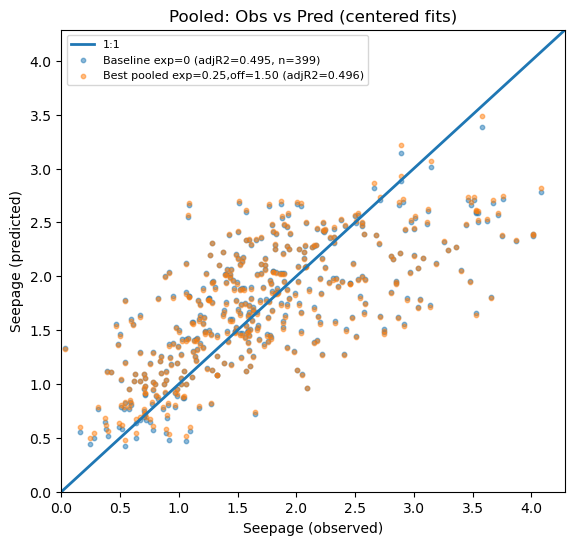

In [6]:

# Scatter overlay: Obs vs Pred (baseline and pooled best)
fit0 = fit_centered(y_all, X0)
fitb = fit_centered(y_all, Xb)

plt.figure(figsize=(6.5,6))
# 1:1
lim = max(np.nanmax(y_all[fit0["mask"]]), np.nanmax(fit0["yhat"][fit0["mask"]]),
          np.nanmax(fitb["yhat"][fitb["mask"]])) * 1.05
grid = np.linspace(0, lim, 200)
plt.plot(grid, grid, linewidth=2, label="1:1")
# scatter
plt.scatter(y_all[fit0["mask"]], fit0["yhat"][fit0["mask"]], s=10, alpha=0.5,
            label=f"Baseline exp=0 (adjR2={fit0['adjR2']:.3f}, n={fit0['n']})")
plt.scatter(y_all[fitb["mask"]], fitb["yhat"][fitb["mask"]], s=10, alpha=0.5,
            label=f"Best pooled exp={best_pool['exponent']:.2f},off={best_pool['offset']:.2f} (adjR2={fitb['adjR2']:.3f})")
plt.xlabel("Seepage (observed)"); plt.ylabel("Seepage (predicted)")
plt.title("Pooled: Obs vs Pred (centered fits)")
plt.legend(loc="upper left", fontsize=8)
plt.xlim(0, lim); plt.ylim(0, lim)
plt.show()


## 3B. By-event optimization (maximize **median** centered $R^2$)

In [21]:

# Per-event grid
by_rows = []
for exp in exponents:
    for off in offsets:
        tab = per_event_R2(df, exp, off, y_col, dh_col, event_col)
        med = float(tab["R2"].median()) if not tab.empty else np.nan
        by_rows.append({"exponent": exp, "offset": off, "median_R2": med, "n_events": int(tab.shape[0])})
by_grid = pd.DataFrame(by_rows)
best_by = by_grid.sort_values("median_R2", ascending=False).iloc[0]
best_by


exponent      1.500000
offset        3.000000
median_R2     0.683306
n_events     27.000000
Name: 90, dtype: float64

In [22]:
by_grid

,exponent,offset,median_R2,n_events
0,0.0,0.00,0.666082,27
1,0.0,0.25,0.666082,27
2,0.0,0.50,0.666082,27
3,0.0,0.75,0.666082,27
4,0.0,1.00,0.666082,27
...,...,...,...,...
112,2.0,2.00,0.674400,27
113,2.0,2.25,0.675763,27
114,2.0,2.50,0.676984,27
115,2.0,2.75,0.678084,27


In [23]:

# Significance vs baseline: paired Wilcoxon on per-event R2
tab_best = per_event_R2(df, best_by["exponent"], best_by["offset"], y_col, dh_col, event_col).rename(columns={"R2":"R2_best","N":"N_best"})
tab_0    = per_event_R2(df, baseline["exponent"], baseline["offset"], y_col, dh_col, event_col).rename(columns={"R2":"R2_0","N":"N_0"})
cmp_b = pd.merge(tab_best[["event","N_best","R2_best"]], tab_0[["event","N_0","R2_0"]], on="event", how="inner")

from scipy.stats import wilcoxon
W_b, p_b = (np.nan, np.nan)
if cmp_b.shape[0] >= 5 and not np.allclose((cmp_b["R2_best"]-cmp_b["R2_0"]).to_numpy(), 0):
    W_b, p_b = wilcoxon(cmp_b["R2_best"], cmp_b["R2_0"], zero_method="wilcox", alternative="two-sided", mode="auto")

print("By-event median best vs baseline:")
print(f"  Best: exp={best_by['exponent']:.2f}, off={best_by['offset']:.2f}, median_R2={best_by['median_R2']:.4f}, events={int(best_by['n_events'])}")
print(f"  Wilcoxon: W={W_b:.3f}, p={p_b:.3f}")
print(f"  Event medians: best={cmp_b['R2_best'].median():.4f} vs baseline={cmp_b['R2_0'].median():.4f}")


By-event median best vs baseline:
  Best: exp=1.50, off=3.00, median_R2=0.6833, events=27
  Wilcoxon: W=98.000, p=0.028
  Event medians: best=0.6833 vs baseline=0.6661


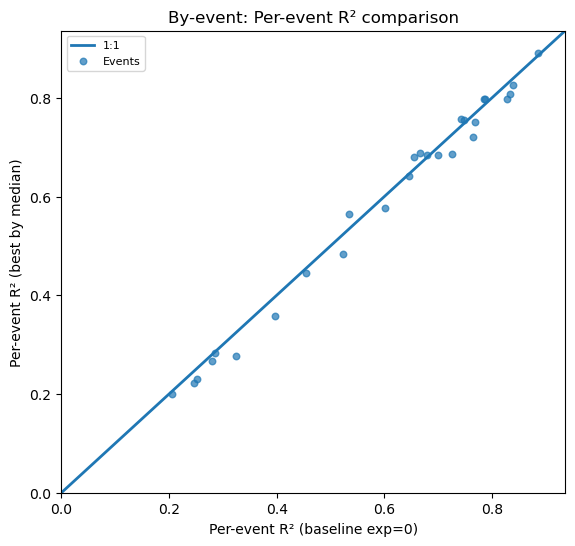

In [24]:

# Scatter: per-event R2 (baseline on x, best on y) with 1:1 line
plt.figure(figsize=(6.5,6))
x = cmp_b["R2_0"].to_numpy(); y = cmp_b["R2_best"].to_numpy()
lim = max(np.nanmax(x), np.nanmax(y)) * 1.05
grid = np.linspace(0, lim, 200)
plt.plot(grid, grid, linewidth=2, label="1:1")
plt.scatter(x, y, s=22, alpha=0.7, label="Events")
plt.xlabel("Per-event R² (baseline exp=0)")
plt.ylabel("Per-event R² (best by median)")
plt.title("By-event: Per-event R² comparison")
plt.legend(loc="upper left", fontsize=8)
plt.xlim(0, lim); plt.ylim(0, lim)
plt.show()


## 3C. By-event optimization (maximize **N-weighted median** centered $R^2$)

In [26]:

# Weighted-median grid
def weighted_median(values, weights):
    v = np.asarray(values, dtype=float)
    w = np.asarray(weights, dtype=float)
    order = np.argsort(v)
    v, w = v[order], w[order]
    cw = np.cumsum(w)
    cutoff = 0.5 * cw[-1]
    idx = np.searchsorted(cw, cutoff)
    return float(v[min(idx, len(v)-1)])

wrows = []
for exp in exponents:
    for off in offsets:
        tab = per_event_R2(df, exp, off, y_col, dh_col, event_col)
        if tab.empty: 
            wmed = np.nan; n_ev = 0
        else:
            tab2 = tab.dropna(subset=["R2","N"])
            wmed = weighted_median(tab2["R2"].values, tab2["N"].values) if len(tab2)>0 else np.nan
            n_ev = int(tab2.shape[0])
        wrows.append({"exponent": exp, "offset": off, "wmedian_R2": wmed, "n_events": n_ev})
wgrid = pd.DataFrame(wrows)
best_w = wgrid.sort_values("wmedian_R2", ascending=False).iloc[0]
best_w


exponent       1.500000
offset         3.000000
wmedian_R2     0.683306
n_events      27.000000
Name: 90, dtype: float64

In [27]:
wgrid

,exponent,offset,wmedian_R2,n_events
0,0.0,0.00,0.680022,27
1,0.0,0.25,0.680022,27
2,0.0,0.50,0.680022,27
3,0.0,0.75,0.680022,27
4,0.0,1.00,0.680022,27
...,...,...,...,...
112,2.0,2.00,0.674400,27
113,2.0,2.25,0.675763,27
114,2.0,2.50,0.676984,27
115,2.0,2.75,0.678084,27


In [28]:

# Significance vs baseline (Wilcoxon + weighted bootstrap CI for weighted mean ΔR2)
tab_best_c = per_event_R2(df, best_w["exponent"], best_w["offset"], y_col, dh_col, event_col).rename(columns={"R2":"R2_best","N":"N_best"})
tab_0_c    = per_event_R2(df, baseline["exponent"], baseline["offset"], y_col, dh_col, event_col).rename(columns={"R2":"R2_0","N":"N_0"})
cmp_c = pd.merge(tab_best_c[["event","N_best","R2_best"]], tab_0_c[["event","N_0","R2_0"]], on="event", how="inner")

# Unweighted Wilcoxon on per-event R2
from scipy.stats import wilcoxon
W_c, p_c = (np.nan, np.nan)
if cmp_c.shape[0] >= 5 and not np.allclose((cmp_c["R2_best"]-cmp_c["R2_0"]).to_numpy(), 0):
    W_c, p_c = wilcoxon(cmp_c["R2_best"], cmp_c["R2_0"], zero_method="wilcox", alternative="two-sided", mode="auto")

# Weighted bootstrap for weighted mean ΔR2
rng = np.random.default_rng(42)
diffs = (cmp_c["R2_best"] - cmp_c["R2_0"]).to_numpy()
weights = np.minimum(cmp_c["N_best"], cmp_c["N_0"]).to_numpy().astype(float)
weights = weights / weights.sum()
B = 2000
wb_means = []
for _ in range(B):
    idx = rng.choice(len(diffs), size=len(diffs), replace=True, p=weights/weights.sum())
    wb_means.append(np.average(diffs[idx], weights=weights[idx]))
wb_means = np.array(wb_means)
ci_lo, ci_hi = np.percentile(wb_means, [2.5, 97.5])
p_boot = 2 * min((wb_means <= 0).mean(), (wb_means >= 0).mean())

print("By-event weighted-median best vs baseline:")
print(f"  Best: exp={best_w['exponent']:.2f}, off={best_w['offset']:.2f}, wmedian_R2={best_w['wmedian_R2']:.4f}, events={int(best_w['n_events'])}")
print(f"  Wilcoxon: W={W_c:.3f}, p={p_c:.3f}")
print(f"  Weighted-mean ΔR² 95% CI: [{ci_lo:.4f}, {ci_hi:.4f}], bootstrap p≈{p_boot:.3f}")
print(f"  Weighted-mean R²: best={np.average(cmp_c['R2_best'], weights=weights):.4f}, baseline={np.average(cmp_c['R2_0'], weights=weights):.4f}")


By-event weighted-median best vs baseline:
  Best: exp=1.50, off=3.00, wmedian_R2=0.6833, events=27
  Wilcoxon: W=98.000, p=0.028
  Weighted-mean ΔR² 95% CI: [-0.0197, -0.0057], bootstrap p≈0.000
  Weighted-mean R²: best=0.5968, baseline=0.6086


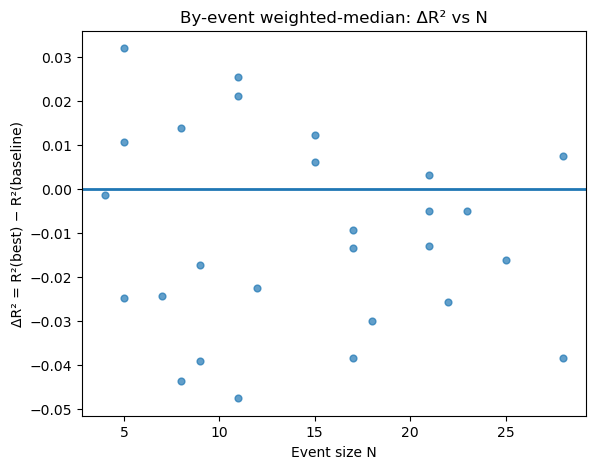

In [29]:

# Scatter: ΔR² vs event size N (for weighted-median best vs baseline)
plt.figure(figsize=(6.5,5))
diff = cmp_c["R2_best"] - cmp_c["R2_0"]
Nw = np.minimum(cmp_c["N_best"], cmp_c["N_0"])
plt.scatter(Nw, diff, s=24, alpha=0.7)
plt.axhline(0, linewidth=2)
plt.xlabel("Event size N")
plt.ylabel("ΔR² = R²(best) − R²(baseline)")
plt.title("By-event weighted-median: ΔR² vs N")
plt.show()


## 4. Export results

In [17]:

# # Save grid CSVs and per-event comparisons for your records
# pooled_path = "/mnt/data/opt_centeredR2_pooled_grid.csv"
# by_path     = "/mnt/data/opt_centeredR2_byEvent_median_grid.csv"
# wmed_path   = "/mnt/data/opt_centeredR2_byEvent_wmedian_grid.csv"
# pooled.to_csv(pooled_path, index=False)
# by_grid.to_csv(by_path, index=False)
# wgrid.to_csv(wmed_path, index=False)

# cmp_b.to_csv("/mnt/data/compare_best_median_vs_exp0_per_event.csv", index=False)
# cmp_c.to_csv("/mnt/data/compare_best_wmedian_vs_exp0_per_event.csv", index=False)

# print("Saved:")
# print(pooled_path)
# print(by_path)
# print(wmed_path)


## 5. Interpretation notes


- We use **centered $R^2$** (with intercept). This is the standard "fraction of variance explained around the mean" metric.
- The **pooled** approach measures a single global fit; the **by-event** approaches evaluate **consistency across closures**.
- **Partial F** tests check whether adding one model's predictor to the other reduces SSE significantly (given an intercept).
- **Wilcoxon** tests compare **paired** per-event $R^2$ without assuming normality.
- The **weighted bootstrap** assesses uncertainty for a **size-weighted average** improvement across events.
